# Ploting sky map

In [ ]:
# # get the data 
! wget 'https://dcc.ligo.org/public/0146/G1701985/001/bayestar_no_virgo.fits.gz'
# unzip
! gunzip bayestar_no_virgo.fits.gz -y

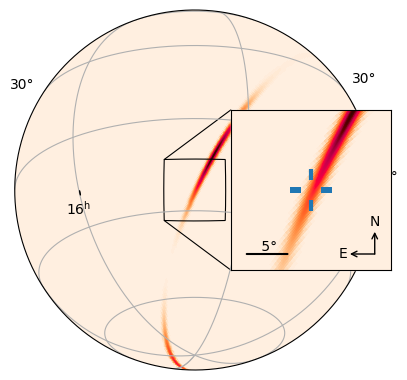

In [5]:
# An example from https://lscsoft.docs.ligo.org/ligo.skymap/plot/allsky.html

from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy import units as u
import ligo.skymap.plot
from matplotlib import pyplot as plt
import numpy as np

url = 'bayestar_no_virgo.fits'
center = SkyCoord.from_name('NGC 4993')

fig = plt.figure(figsize=(4, 4), dpi=100)

ax = plt.axes(
    [0.05, 0.05, 0.9, 0.9],
    projection='astro globe',
    center=center)

ax_inset = plt.axes(
    [0.59, 0.3, 0.4, 0.4],
    projection='astro zoom',
    center=center,
    radius=10*u.deg)

for key in ['ra', 'dec']:
    ax_inset.coords[key].set_ticklabel_visible(False)
    ax_inset.coords[key].set_ticks_visible(False)
ax.grid()
ax.mark_inset_axes(ax_inset)
ax.connect_inset_axes(ax_inset, 'upper left')
ax.connect_inset_axes(ax_inset, 'lower left')
ax_inset.scalebar((0.1, 0.1), 5 * u.deg).label()
ax_inset.compass(0.9, 0.1, 0.2)

ax.imshow_hpx(url, cmap='cylon')
ax_inset.imshow_hpx(url, cmap='cylon')
ax_inset.plot(
    center.ra.deg, center.dec.deg,
    transform=ax_inset.get_transform('world'),
    marker=ligo.skymap.plot.reticle(),
    markersize=30,
    markeredgewidth=3)

In [166]:
# looking at the contents of the data
# import bayestar_no_virgo.fits
import healpy as hp
from astropy.io import fits
import numpy as np

filename = 'bayestar_no_virgo.fits'
hdulist = fits.open(filename)
hdulist.info()

Filename: bayestar_no_virgo.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU     55   12582912R x 4C   [D, D, D, D]   


In [167]:
data = hdulist[1].data
data.columns

ColDefs(
    name = 'PROB'; format = 'D'; unit = 'pix-1'
    name = 'DISTMU'; format = 'D'; unit = 'Mpc'
    name = 'DISTSIGMA'; format = 'D'; unit = 'Mpc'
    name = 'DISTNORM'; format = 'D'; unit = 'Mpc-2'
)

In [116]:
12*(2**10)**2

12582912

In [128]:
data

FITS_rec([(3.10507952e-15, -57.73031674, 29.47331639, 0.17684405),
          (3.10507952e-15, -57.73031674, 29.47331639, 0.17684405),
          (3.10507952e-15, -57.73031674, 29.47331639, 0.17684405), ...,
          (2.88104826e-45,  14.77421207,  0.97870394, 0.00456131),
          (2.88104826e-45,  14.77421207,  0.97870394, 0.00456131),
          (2.88104826e-45,  14.77421207,  0.97870394, 0.00456131)],
         dtype=(numpy.record, [('PROB', '>f8'), ('DISTMU', '>f8'), ('DISTSIGMA', '>f8'), ('DISTNORM', '>f8')]))

In [121]:
np.array(data['PROB'])

array([3.10507952e-15, 3.10507952e-15, 3.10507952e-15, ...,
       2.88104826e-45, 2.88104826e-45, 2.88104826e-45])

In [120]:
np.array(test['PROBDENSITY'])

array([0.02662322, 0.02542055, 0.02617098, ..., 0.10926948, 0.11521613,
       0.11230444])

In [127]:
np.array(test['UNIQ'])[-23:]

array([61093, 61094, 61095, 61096, 61097, 61098, 61099, 61100, 61101,
       61102, 61103, 61104, 61105, 61106, 61107, 61112, 61113, 61114,
       61115, 61116, 61117, 61118, 61119], dtype=int64)

## Getting data at the right format 

* ligo.skymap uses fits files

* get a random event as an example

In [54]:
from lal import CreateREAL8FrequencySeries
from lalsimulation import SimNoisePSD, SimNoisePSDaLIGOZeroDetHighPowerPtr
from ligo.skymap.io.events import Event, SingleEvent
import numpy as np

class RandomEvent(Event):

    def __init__(self):
        self._singles = [RandomSingleEvent('H1'), RandomSingleEvent('L1')]
        self._template_args = {'mass1': np.random.uniform(1.0, 3.0),
                               'mass2': np.random.uniform(1.0, 3.0)}

    @property
    def singles(self):
        return self._singles

    @property
    def template_args(self):
        return self._template_args


class RandomSingleEvent(SingleEvent):

    def __init__(self, detector):
        self._detector = detector
        self._snr = np.random.uniform(1, 10)
        self._phase = np.random.uniform(-np.pi, np.pi)
        self._time = np.random.uniform(1e9, 1.1e9)
        self._psd = CreateREAL8FrequencySeries(name=None, epoch=None, f0=0.0,
                                               deltaF=1.0, sampleUnits=None,
                                               length=16384)
        SimNoisePSD(psd=self._psd, flow=10.0,
                    psdfunc=SimNoisePSDaLIGOZeroDetHighPowerPtr)
        self._psd.data.data[self._psd.data.data == 0] = np.inf

    @property
    def detector(self):
        return self._detector

    @property
    def snr(self):
        return self._snr

    @property
    def phase(self):
        return self._phase

    @property
    def time(self):
        return self._time

    @property
    def zerolag_time(self):
        return self._time

    @property
    def psd(self):
        return self._psd


np.random.seed(0)
event = RandomEvent()
print(event)

<RandomEvent(singles=[<RandomSingleEvent(detector='H1', snr=5.939321535345923, phase=1.352074665052471, time=1060276337.6071644)>, <RandomSingleEvent(detector='L1', snr=5.903948646972072, phase=-0.4796910430674712, time=1064589411.3066657)>])>


In [55]:
bys = RandomEvent()

In [56]:
from ligo.skymap import bayestar
test = bayestar.localize(event=bys)
test.keys()

Truncating PSD at 0.95 of maximum frequency to suppress rolloff artifacts. This option may be removed in the future.
Truncating PSD at 0.95 of maximum frequency to suppress rolloff artifacts. This option may be removed in the future.
Template is unspecified; using ER10/O2 uberbank criterion
Assuming PSD is infinite at 0.0078125 Hz because PSD is only sampled down to 1 Hz
Assuming PSD is infinite at 0.0078125 Hz because PSD is only sampled down to 1 Hz
No SNR time series found, so we are creating a zero-noise SNR time series from the whitened template's autocorrelation sequence. The sky localization uncertainty may be underestimated.


['UNIQ', 'PROBDENSITY', 'DISTMU', 'DISTSIGMA', 'DISTNORM']

In [208]:
import ligo.skymap as ls
fits_test = ls.io.fits.write_sky_map('test.fits',test)

In [ ]:
hdulist[1].header

In [61]:
filename = 'test.fits'
hdulist = fits.open(filename)
hdulist.info()

Filename: test.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU     50   19200R x 5C   [K, D, D, D, D]   


In [62]:
data = hdulist[1].data
data.columns

ColDefs(
    name = 'UNIQ'; format = 'K'
    name = 'PROBDENSITY'; format = 'D'; unit = 'sr-1'
    name = 'DISTMU'; format = 'D'; unit = 'Mpc'
    name = 'DISTSIGMA'; format = 'D'; unit = 'Mpc'
    name = 'DISTNORM'; format = 'D'; unit = 'Mpc-2'
)

ValueError: nside must be a power of two

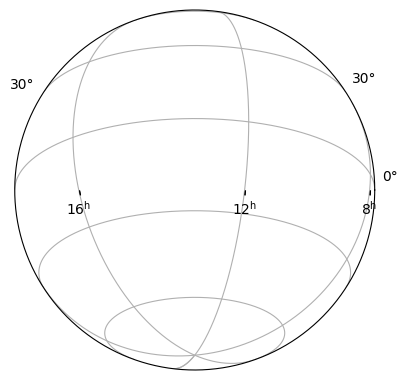

In [63]:
url = 'test.fits'

fig = plt.figure(figsize=(4, 4), dpi=100)

ax = plt.axes(
    [0.05, 0.05, 0.9, 0.9],
    projection='astro globe',
    center=center)

for key in ['ra', 'dec']:
    ax_inset.coords[key].set_ticklabel_visible(False)
    ax_inset.coords[key].set_ticks_visible(False)
ax.grid()

ax.imshow_hpx(url, cmap='cylon')
ax_inset.imshow_hpx(url, cmap='cylon')
ax_inset.plot(
    center.ra.deg, center.dec.deg,
    transform=ax_inset.get_transform('world'),
    marker=ligo.skymap.plot.reticle(),
    markersize=30,
    markeredgewidth=3)

In [71]:
# this the replication of the function where error arises
# the value should be True
nside = np.sqrt(len(test) / 12)
log_2_nside = np.round(np.log2(nside))
2 ** log_2_nside == nside

False

### Let's tackle problem by using the original data length

In [151]:
len(data['PROB'])

12582912

In [152]:
len(test)

19200

In [153]:
# I am assuming idx shows the event position in pixel map
idx = test['UNIQ']
np.array(idx)

array([ 1104,  1105,  1107, ..., 61117, 61118, 61119], dtype=int64)

In [154]:
test.colnames

['UNIQ', 'PROBDENSITY', 'DISTMU', 'DISTSIGMA', 'DISTNORM']

In [155]:
data['PROB']

array([3.10507952e-15, 3.10507952e-15, 3.10507952e-15, ...,
       2.88104826e-45, 2.88104826e-45, 2.88104826e-45])

In [168]:
data = hdulist[1].data
data.columns

ColDefs(
    name = 'PROB'; format = 'D'; unit = 'pix-1'
    name = 'DISTMU'; format = 'D'; unit = 'Mpc'
    name = 'DISTSIGMA'; format = 'D'; unit = 'Mpc'
    name = 'DISTNORM'; format = 'D'; unit = 'Mpc-2'
)

In [182]:
from astropy.table import Table, Column
import numpy as np

# Assuming 'test' is your existing Table

# Create a new table to store the modified columns
new_table = Table()
idx = test['UNIQ']

col_name = 'PROB'
column_data = test['PROBDENSITY']
old_data = data[col_name]
# old_data[idx] = column_data
new_table[col_name] = old_data

col_name = 'DISTMU'
column_data = test['DISTMU']
old_data = data[col_name]
# old_data[idx] = column_data
new_table[col_name] = old_data

col_name = 'DISTSIGMA'
column_data = test['DISTSIGMA']
old_data = data[col_name]
# old_data[idx] = column_data
new_table[col_name] = old_data

col_name = 'DISTNORM'
column_data = test['DISTNORM']
old_data = data[col_name]
# old_data[idx] = column_data
new_table[col_name] = old_data



In [183]:
import ligo.skymap as ls
# save the new data
fits_test = ls.io.fits.write_sky_map('test2.fits',new_table)

In [184]:
# this the replication of the function where error arises
# the value should be True
nside = np.sqrt(len(new_table) / 12)
log_2_nside = np.round(np.log2(nside))
2 ** log_2_nside == nside

True

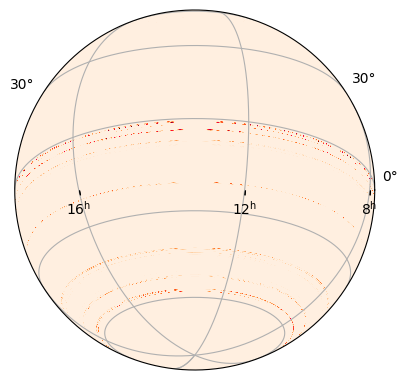

In [205]:
url = 'test2.fits'
#url = 'bayestar_no_virgo.fits'

fig = plt.figure(figsize=(4, 4), dpi=100)

ax = plt.axes(
    [0.05, 0.05, 0.9, 0.9],
    projection='astro globe',
    center=center)

for key in ['ra', 'dec']:
    ax_inset.coords[key].set_ticklabel_visible(False)
    ax_inset.coords[key].set_ticks_visible(False)
ax.grid()

ax.imshow_hpx(url, cmap='cylon')
# ax_inset.imshow_hpx(url, cmap='cylon')
# ax_inset.plot(
#     center.ra.deg, center.dec.deg,
#     transform=ax_inset.get_transform('world'),
#     marker=ligo.skymap.plot.reticle(),
#     markersize=30,
#     markeredgewidth=3)

In [186]:
import healpy as hp
from astropy.io import fits
import numpy as np

filename = 'test2.fits'
hdulist2 = fits.open(filename)
hdulist2.info()

Filename: test2.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU     25   12582912R x 4C   [D, D, D, D]   


In [187]:
data2 = hdulist2[1].data
data2.columns

ColDefs(
    name = 'PROB'; format = 'D'; unit = 'pix-1'
    name = 'DISTMU'; format = 'D'; unit = 'Mpc'
    name = 'DISTSIGMA'; format = 'D'; unit = 'Mpc'
    name = 'DISTNORM'; format = 'D'; unit = 'Mpc-2'
)

In [188]:
filename = 'bayestar_no_virgo.fits'
hdulist = fits.open(filename)
hdulist.info()

Filename: bayestar_no_virgo.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU     55   12582912R x 4C   [D, D, D, D]   


In [204]:
hdulist[1]['PROB']

TypeError: 'BinTableHDU' object is not subscriptable

In [189]:
data = hdulist[1].data
data.columns

ColDefs(
    name = 'PROB'; format = 'D'; unit = 'pix-1'
    name = 'DISTMU'; format = 'D'; unit = 'Mpc'
    name = 'DISTSIGMA'; format = 'D'; unit = 'Mpc'
    name = 'DISTNORM'; format = 'D'; unit = 'Mpc-2'
)

In [206]:
hdulist2[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   32 / length of dimension 1                          
NAXIS2  =             12582912 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    4 / number of table fields                         
TTYPE1  = 'PROB    '                                                            
TFORM1  = 'D       '                                                            
TUNIT1  = 'pix-1   '                                                            
TTYPE2  = 'DISTMU  '                                                            
TFORM2  = 'D       '        

In [198]:
hdulist[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   32 / length of dimension 1                          
NAXIS2  =             12582912 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    4 / number of table fields                         
TTYPE1  = 'PROB    '                                                            
TFORM1  = 'D       '                                                            
TUNIT1  = 'pix-1   '                                                            
TTYPE2  = 'DISTMU  '                                                            
TFORM2  = 'D       '        

In [200]:
hdulist2[1].header = hdulist[1].header

In [ ]:
np.sum(data['PROB']-data2['PROB'])

* I don't know whether this is right. ???